In [1]:
from collections import namedtuple, deque
from itertools import count
import numpy as np
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image

In [2]:
import gym

In [3]:
env = gym.make('CartPole-v0')

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


In [5]:
plt.ion()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))

In [8]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [9]:

class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.head(x.view(x.size(0), -1))
        return x

In [10]:
resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=Image.CUBIC),
    T.ToTensor()
])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)
    
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4): int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(0, view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = resize(screen).unsqueeze(0)
    return screen


    
    

C:\Users\chtti\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


C:\Users\chtti\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


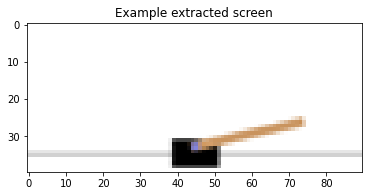

In [11]:
env.reset()
for i in range(20):
    env.step(0)

plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.title('Example extracted screen')
plt.show()


In [12]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

env.reset()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0



In [13]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]],
                            device=device,
                            dtype=torch.long)
    

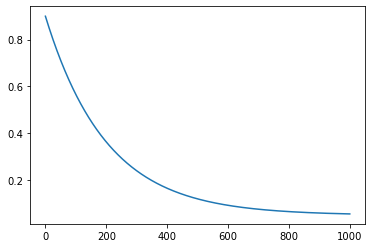

In [14]:

def get_eps_threshold(steps_done):
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)

plt.figure()
x = list(range(1000))
y = [get_eps_threshold(i) for i in x]
plt.plot(x, y)
plt.show()


In [15]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)
    
    if is_ipython:
        display.clear_output(wait=True)
    #    display.display(plt.gcf())
    



In [16]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
        
    

In [22]:
num_episodes = 300

for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    
    state = current_screen - last_screen
    
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        memory.push(state, action, next_state, reward)
        state = next_state
        
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

KeyboardInterrupt: 

env.reset()
last_screen = get_screen()
current_screen = get_screen()

state = current_screen - last_screen

action = select_action(state)

_, reward, done, _ = env.step(action.item())
reward = torch.tensor([reward], device=device)
print(reward, done)

last_screen = current_screen
current_screen = get_screen()
next_state = current_screen - last_screen

memory.push(state, action, next_state, reward)

transition = memory.sample(3)

batch = Transition(*zip(*transition))

non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

non_final_mask

non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)

action_batch

state_action_values = policy_net(state_batch)

state_action_values

state_action_values = state_action_values.gather(1, action_batch)

state_action_values

next_state_values = torch.zeros(3, device=device)
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

next_state_values

expected_state_action_values = (next_state_values * GAMMA) + reward_batch

expected_state_action_values

criterion = nn.SmoothL1Loss()

loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

optimizer.zero_grad()
loss.backward()


for param in policy_net.parameters():
    param.grad.data.clamp_(-1, 1)

optimizer.step()

In [28]:
env.reset()
last_screen = get_screen()
current_screen = get_screen()
    
state = current_screen - last_screen

with torch.no_grad():
    for t in count():
        action = policy_net(state).max(1)[1]
        _, reward, done, _ = env.step(action.item())
        #env.render()
        
        last_screen = current_screen
        current_screen = get_screen()
        state = current_screen - last_screen
        
        if done:
            print(t + 1)
            break


10
